<div>
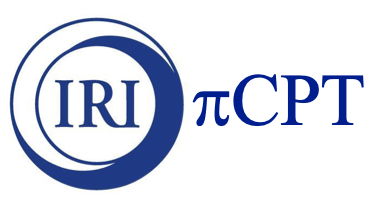
</div>

## s2sv1.9 (6 Nov 2020)
## Produce S2S (un)calibrated forecasts and assess associated skill 


#### Requires:
CPTv16.5.2+

#### Authors: 
Authors: ÁG Muñoz (agmunoz@iri.columbia.edu), AW Robertson (awr@iri.columbia.edu), Cuihua Li (OCP), Bohar Singh (IRI),  T Turkington (NEA), SJ Mason (IRI)

#### Acknowledgements: 
Rémi Cousin (IRI, key Ingrid code), James Doss-Gollin (Columbia Water Center, original download Python functions).
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson). 

#### Version log
See version.log in Github

#### Workflow
<div>
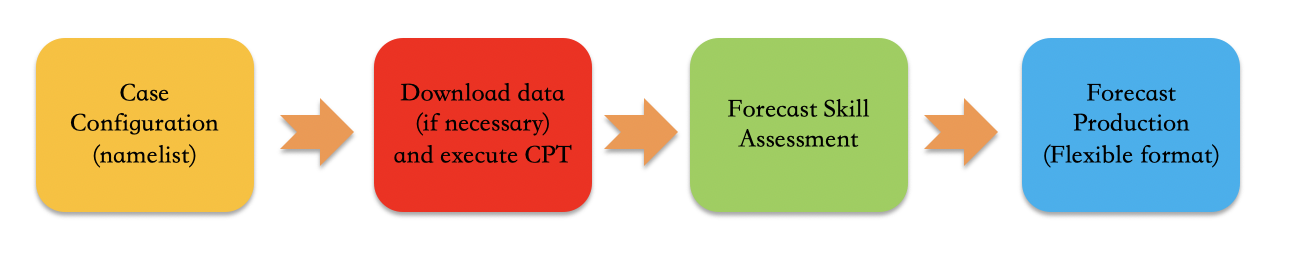
</div>

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7), CHIRPS, CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* Probabilistic forecasts, in terciles and flex format.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is not deleted anymore at the beginning of the process, but scripts are!
2. Initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.

### Namelist section
Here the user configures the case study

In [1]:
#=================================================================================
#         Case name (name of the case/experiment, try one word)
#---------------------------------------------------------------------------------
case='IAS_s2s'

#---------------------------------------------------------------------------------
#                       Some folder and file options:
#---------------------------------------------------------------------------------
# Working directory --it should exist!!! (this is the place where the .py functions, notebooks, and .IRIDLAUTH is)
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/PyCPT/iri-pycpt/'

# PATH to CPT root directory
cptdir='/Users/kjhall/CPT/16.5.8/'     #'/opt/CPT/bin/'

########Model (choose between ECMWF, CFSv2, GEFS, CFSv2_SubX, GEPS6)
model='ECMWF'

########Obs (choose between CHIRPS, TRMM, CPC, IMD1deg, IMDp25deg)
obs='CHIRPS'

########MOS method (choose between None, PCR, CCA and ELR)
MOS='CCA'

#----------------------------------------------------------------------------------------------------
#                                       Forecast date  
#  If ECMWF, it needs to be a Monday or a Thursday! CFSv2: any day; GEFS: Wednesdays GEPS6: Thrusday
#----------------------------------------------------------------------------------------------------

mon='Jun' 	# Forecast month 

fyr=2020 	# Forecast year

fday=1 	# Forecast day  (Monday and Thursday in ECMWF model; yesterday in CFSv2: real time)
#----------------------------------------------------------------------------------------------------
#                          Traning Season (One month or Three MOnth)
#----------------------------------------------------------------------------------------------------
#training_season=mon 
training_season='May-Jul'  # with *mon* in the middle, e.g., 'May-Jul' if mon='Jun'

#lit: Initial training period for retroactive forecasts (in timesteps; e.g., 80 for ECMWF, 28 for CFSv2)
#liti:Update interval for retroactive forecasts (in timesteps; e.g., 10)

#----------------------------------------------------------------------------------------------------
#                                           Switches:
#----------------------------------------------------------------------------------------------------
force_download = False   #force download of data files, even if they already exist locally
# Rainfall frequency switch 
rainfall_frequency = False  #False gives total rainfall for forecast periods

wetday_threshold = 3 #WET day threshold (mm) --only used if rainfall_frequency is True!
threshold_pctle = False    #False for threshold in mm; Note that if True then if counts DRY days!!!

#----------------------------------------------------------------------------------------------------
#                              Spatial domain for predictor
#----------------------------------------------------------------------------------------------------

nla1=32 	# Northernmost latitude
sla1=1 	# Southernmost latitude
wlo1=-103 	# Westernmost longitude
elo1=-75 	# Easternmost longitude

# Spatial domain for predictand

nla2=29 	# Northernmost latitude
sla2=2 	# Southernmost latitude
wlo2=-102 	# Westernmost longitude
elo2=-76 	# Easternmost longitude

#-------------------------------------------------------------------------------------------------------------
#  Forecast lead interval  -- This counts using L, the lead time; e.g., ECMWF L=0..46 (NOT calendar days)
#-------------------------------------------------------------------------------------------------------------
nwk=4 # Number of weeks to process (leads)
# Lists for looping over lead times -- ALL these arrays should have the same dimension (see nwk above), as they correspond

wk =   [1       ,2       ,3       ,34       ,4       ]    # week-lead number label (e.g., corresponding to week1, week2, week3, week4, week1-4/month 1)
wknam= ['Week 1','Week 2','Week 3','Week 3-4','Month 1']  #naming the weeks (for plots) --can use a different language here
day1 = [1       ,7       ,14      ,14      ,21        ]   # first lead day of target weeks 
day2 = [7       ,14      ,21      ,28      ,28       ]    # last lead day of target weeks 

# ECMWF - first day is day 0, 0000Z accumulated rainfall; specify day1=1 for week 1
# GEFS/GEPS - first day is day 0.5 (daily average rainfall rate); specify day1=0 for week 1
# CFSv2 - first day is day 1, 0000Z accumulated rainfall over the first day; specify day1=1 for week 1 

In [8]:
########Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

########Model-dependent parameters
from urllib import parse
GEPShdate1 = 'dummy_string'
if model=='CFSv2':
    hstep = 7 # use all starts in the trainng period with this daily step between them 
    nlag  = 3  # length of the lagged ensemble in days
    ntrain= 55 # Length of training period (5 weeks x 11 hindcast years) (363 before)
    lit =  28
    liti = 10
elif model=='ECMWF' or model=='ECMWFrt':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 160  # Length of training period
    lit =  110
    liti = 20
elif model=='GEFS':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 219  # Length of training period (1999-2016)
    lit =  100
    liti = 20
elif model=='GEPS6':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 260  # Length of training period (1998-2017) 
    GEPShdate1 = '0000 4 Jun' # first hindcast date each year in training season
    # Must be a THURSDAY in the forecast year since GEPS is an on-the-fly model
    GEPShdate1 = parse.quote(GEPShdate1)
    lit =  120
    liti = 20
elif model=='CFSv2_SubX':
    hstep = 7 # use all starts in the trainng period with this daily step between them 
    nlag  = 3  # length of the lagged ensemble in days
    ntrain= 234 # Length of training period for 3 month season (1638/7=234)
    lit =  100
    liti = 20
else:
    print ("Model option is invalid")
    
########Observation dataset URLs
if obs == 'TRMM':
    obs_source = 'SOURCES/.NASA/.GES-DAAC/.TRMM_L3/.TRMM_3B42/.v7/.daily/.precipitation/X/0./1.5/360./GRID/Y/-50/1.5/50/GRID'
    obsclimo_source = ''
    hdate_last = 2014
elif obs == 'CPC':
    obs_source = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.extREALTIME/.rain/X/0./.5/360./GRID/Y/-90/.5/90/GRID'
    obsclimo_source = ''
    hdate_last = 2018
elif obs == 'CHIRPS':
    obs_source = 'SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/-180./.5/180./GRID/Y/-90/.5/90/GRID'
    obsclimo_source = 'home/.mbell/.UCSB/.v2p0/.daily-improved/.global/.0p25/.climatology/.pc9514/.prcp/X/-180./.5/180./GRID/Y/-90/.5/90/GRID'
    obsclimo2_source = 'SOURCES/.ECMWF/.S2S/.climatologies/.observed/.CHIRPS/.prcpSmooth/X/-180./.5/180./GRID/Y/-90/.5/90/GRID'
    hdate_last = 2018
elif obs == 'IMD1deg':
    obs_source = 'SOURCES/.IMD/.NCC1-2005/.v4p0/.rf'
    obsclimo_source = ''
    hdate_last = 2015
elif obs == 'IMDp25deg':
    obs_source = 'SOURCES/.IMD/.RF0p25/.gridded/.daily/.v1901-2015/.rf'
    obsclimo_source = ''
    hdate_last = 2016
else:
    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
elif MOS=='PCR':
    mpref='PCR'
elif MOS=='ELR':
    mpref='ELRho'
#else:
#    print ("MOS option is invalid")

# S2S Database key
print("PyCPT folder is:")
%cd $workdir
!mkdir -p $case
with open(workdir+'.IRIDLAUTH') as file:
    authkey = file.read() 


PyCPT folder is:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s


### End of namelist section

#### Load Libraries

In [9]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions import *
from pycpt_dictionary import dic_s2s
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python libraries loaded")
print("Now in the work directory:")
%cd $case
workdir = os.getcwd()

Python libraries loaded
Now in the work directory:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s


In [10]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')

print("")
print("Creating input, output and script folders, if not already there...")
#print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p input/noMOS
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*
!mkdir -p output/figures
# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("")
print("CPT environment loaded. Using this CPT version:")
print(cptdir)

Predictand is Rainfall Total (mm)

Creating input, output and script folders, if not already there...
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s
zsh:1: no matches found: scripts/*

CPT environment loaded. Using this CPT version:
/Users/kjhall/CPT/16.5.8/


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

Forecast date is 1 Jun 2020

     June 2020
Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7
 8  9 10 11 12 13 14
15 16 17 18 19 20 21
22 23 24 25 26 27 28
29 30

     July 2020
Mo Tu We Th Fr Sa Su
       1  2  3  4  5
 6  7  8  9 10 11 12
13 14 15 16 17 18 19
20 21 22 23 24 25 26
27 28 29 30 31



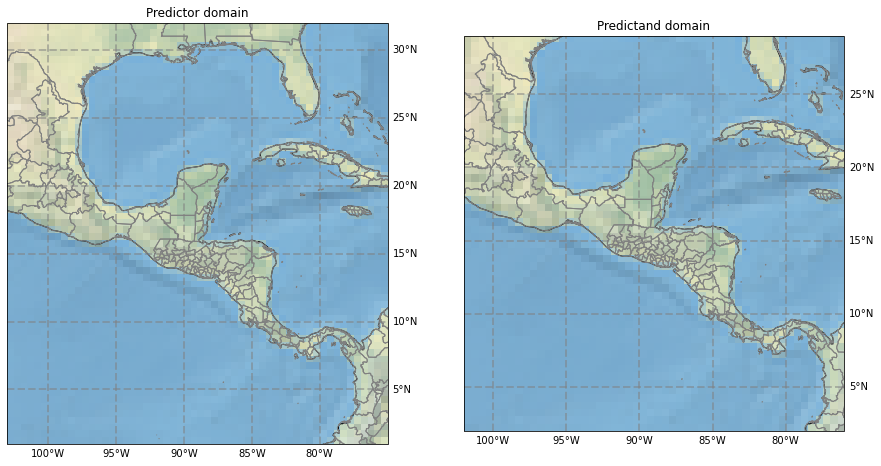

In [11]:
#Print calendars
print('Forecast date is '+str(fday)+' '+mon+' '+str(fyr))
print('')
c=calendar.TextCalendar(calendar.MONDAY)
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)))
if list(calendar.month_abbr).index(mon)+1==13:
    print(c.formatmonth(fyr+1,1))
else:
    print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)+1))

#Plot domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2)

# Download data if necessary, and run CPT
This is the core section of PyCPT, in charge of downloading data and running the skill assessment and forecast sections of the job. This section typically takes some time to be executed.  

In [12]:
for L in range(nwk):
   nday=day2[L]-day1[L]	# Length of target period (days) 
   print("New folder:")
   %cd $workdir/input

   PrepFiles(rainfall_frequency,threshold_pctle, wlo1, wlo2,elo1, elo2,sla1, sla2,nla1, nla2, day1[L], day2[L], fday, nday, fyr, mon, os, authkey, wk[L], wetday_threshold, nlag, training_season, hstep, model, obs_source, obsclimo_source, obsclimo2_source, hdate_last, GEPShdate1,force_download,mpref,dic_s2s)
 
   print("New folder:")
   %cd $workdir/scripts

   CPTscript(mon,fday,lit,liti,wk[L],nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,training_season,ntrain,rainfall_frequency,MOS)

   print('Executing CPT for Week '+str(wk[L])+'... This might take a while... (want to grab a tea or a coffee?)')
   try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_log_'+training_season+'_ini'+mon+str(fday)+'_'+str(fyr)+'_wk'+str(wk[L])+'.txt',stderr=subprocess.STDOUT, shell=True)
   except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
   print('\033[1m----------------------------------------------\033[0;0m')
   print('\033[1mWeek '+str(wk[L])+' calculations completed!\033[0;0m')
   print('\033[1mSee output folder, and check scripts/CPT_log_'+training_season+'_ini'+mon+str(fday)+'_'+str(fyr)+'_wk'+str(wk[L])+'.txt for log\033[0;0m')
   print('\033[1mQuick error report from CPT (if any):\033[0;0m')
   with open('CPT_log_'+training_season+'_ini'+mon+str(fday)+'_'+str(fyr)+'_wk'+str(wk[L])+'.txt', "r") as fp:
        for line in lines_that_contain("Error:", fp):
            print (line)
   print('\033[1m----------------------------------------------\033[0;0m')
   print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

New folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/input
Hindcasts file doesn't exist --SOLVING: downloading file

 Hindcasts URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/1/32/RANGE/X/-103/-75/RANGE/L/(1)/(7)/VALUES/S/(0000%201%20Jun%202020)%20(2300%2028%20Jun%202020)/RANGE/%5BL%5Ddifferences/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/-999/setmissing_value/hdate/(2000)/(2018)/RANGE/dup/%5Bhdate%5Daverage/sub/%5BM%5Daverage/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202020-01-01)/streamgridunitconvert/S//units//days/def/L/hdate/add/add/0/RECHUNK/L/removeGRID//name//T/def/2/%7Bexch%5BS/hdate%5D//I/nchunk/NewIntegerGRID/replaceGRIDstream%7Drepeat/use_as_grid/T/grid%3A//name/(T)/def//units/(months%20since%201960-01-01)/def//standard_name/(time)/def//pointwidth/1/def/16/Jan/1901/ensotime/12./16/Jan/2060/ensotime/%3Agrid/replaceGRID/

100  731k  100  731k    0     0   271k      0  0:00:02  0:00:02 --:--:--  271k
Obs:precip file ready to go
----------------------------------------------
Forecasts file doesn't exist --SOLVING: downloading file

 Forecast URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.forecast/.perturbed/.sfc_precip/.tp/Y/1/32/RANGE/X/-103/-75/RANGE/L/(7)/(14)/VALUES/S/(0000%201%20Jun%202020)/VALUE/%5BL%5Ddifferences/%5BM%5Daverage/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/1/32/RANGE/X/-103/-75/RANGE/L/(7)/(14)/VALUES/S/(0000%201%20Jun%202020)/VALUE/%5BL%5Ddifferences/%5BM%5Daverage/%5Bhdate%5Daverage/sub/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/grid%3A//name/(T)/def//units/(months%20since%201960-01-01)/def//standard_name/(time)/def//pointwidth/1/def/1/Jan/3001/ensotime/12.0/1/Jan/3001/ensotime/%3Agrid/addGRID/T//pointwidth/0/def/pop//name/(tp)/def//units/(mm)/def//long_name/(precipitation_amount)/def/-999/setmissing_value/%5BX/Y%5D

100  308k  100  308k    0     0   538k      0 --:--:-- --:--:-- --:--:--  537k
Hindcasts file ready to go
----------------------------------------------
Obs precip file doesn't exist --SOLVING: downloading file

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.sfc_precip/.tp/Y/2/29/RANGE/X/-102/-76/RANGE/L/(14)/(28)/VALUES/S/(0000%201%20Jun%202020)%20(2300%2028%20Jun%202020)/RANGE/%5BL%5Ddifferences/c%3A//name//water_density/def/998/(kg/m3)/%3Ac/div//mm/unitconvert/-999/setmissing_value/hdate/(2000)/(2018)/RANGE/dup/%5Bhdate%5Daverage/sub/%5BM%5Daverage/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202020-01-01)/streamgridunitconvert/S//units//days/def/L/hdate/add/add/0/RECHUNK/L/removeGRID//name//T/def/2/%7Bexch%5BS/hdate%5D//I/nchunk/NewIntegerGRID/replaceGRIDstream%7Drepeat/use_as_grid/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/X/-180./.5/

## Skill maps
Now that everything has been computed and all files are saved, this section plots deterministic and probabilistic skill maps.

New folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/output


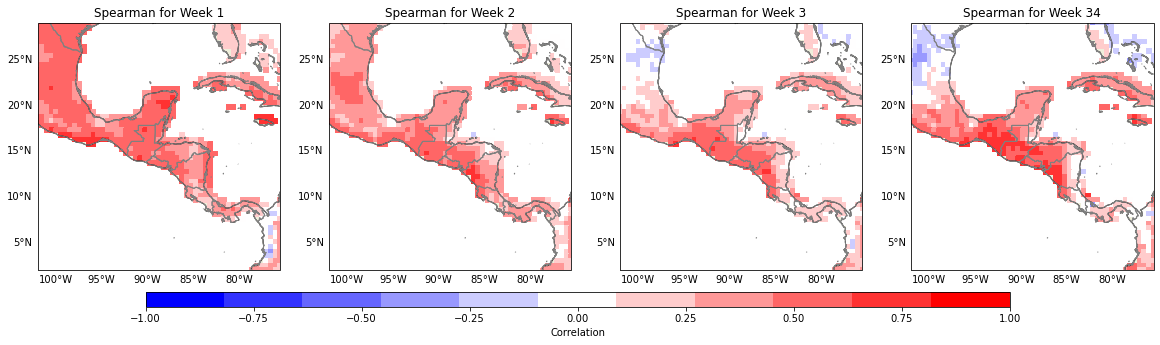

----------------------------------------------



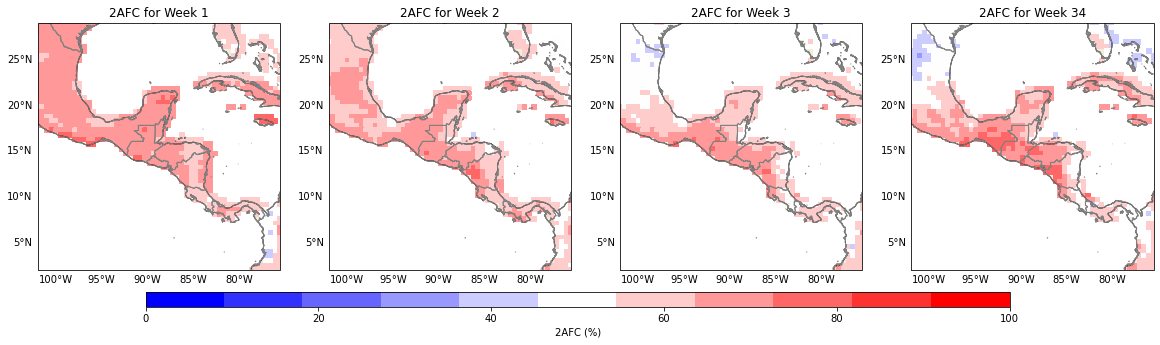

----------------------------------------------



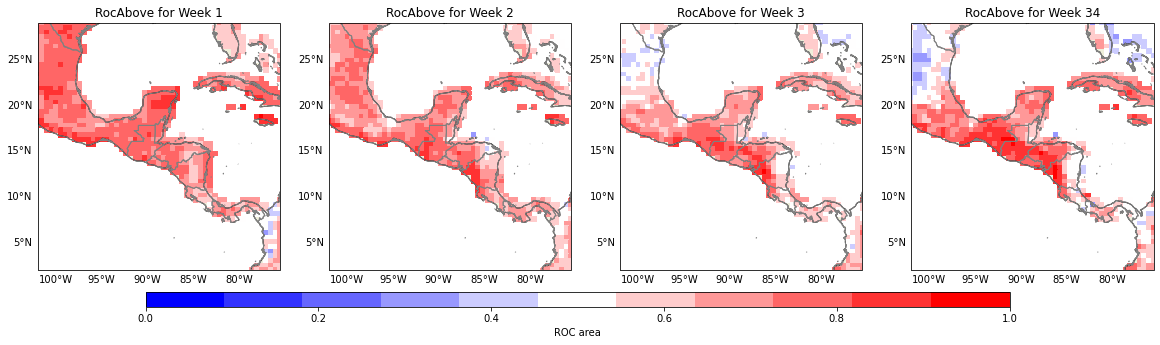

----------------------------------------------



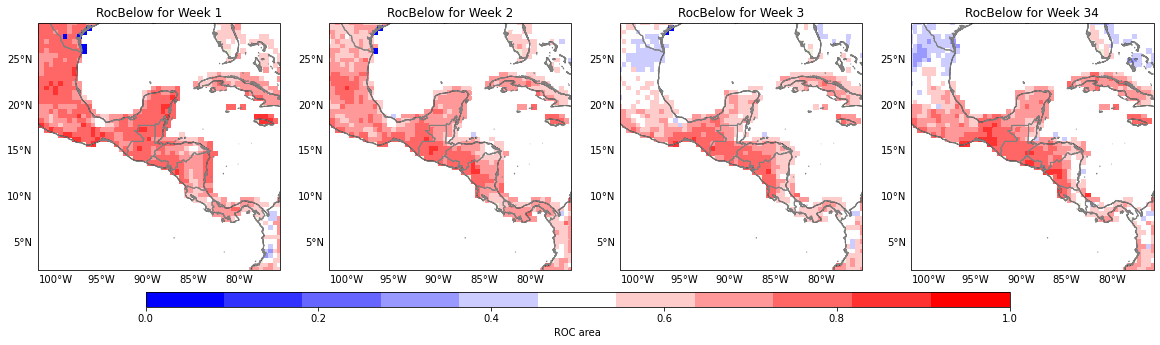

----------------------------------------------



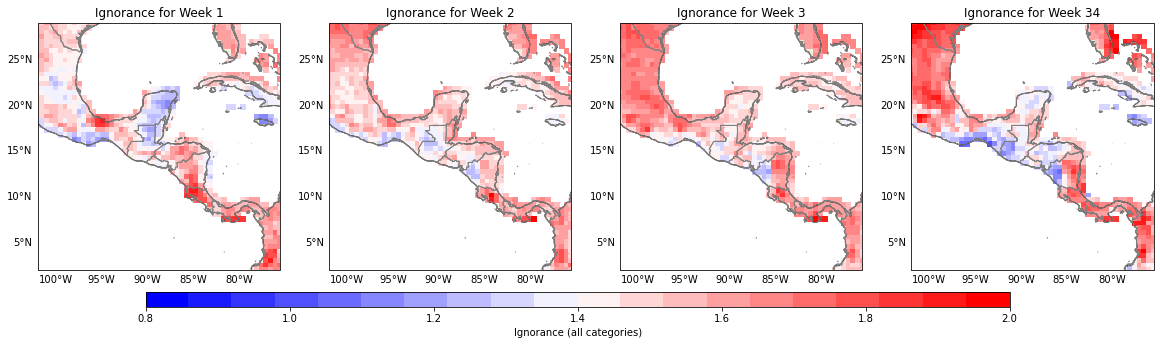

----------------------------------------------



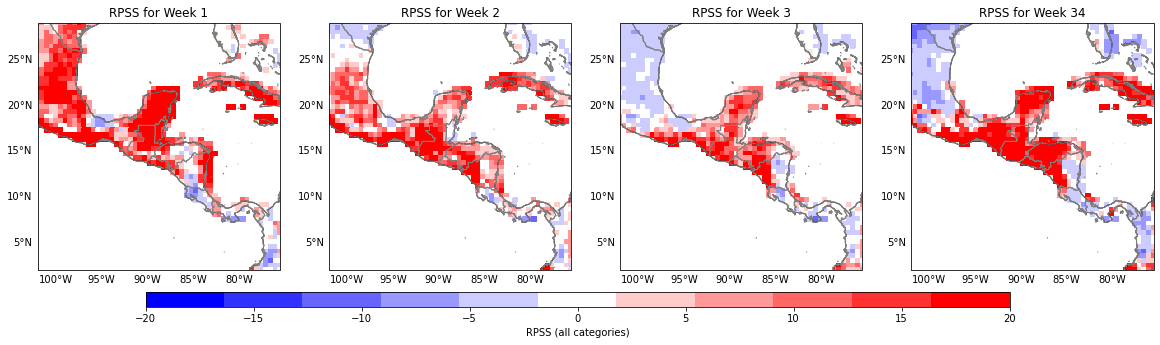

----------------------------------------------



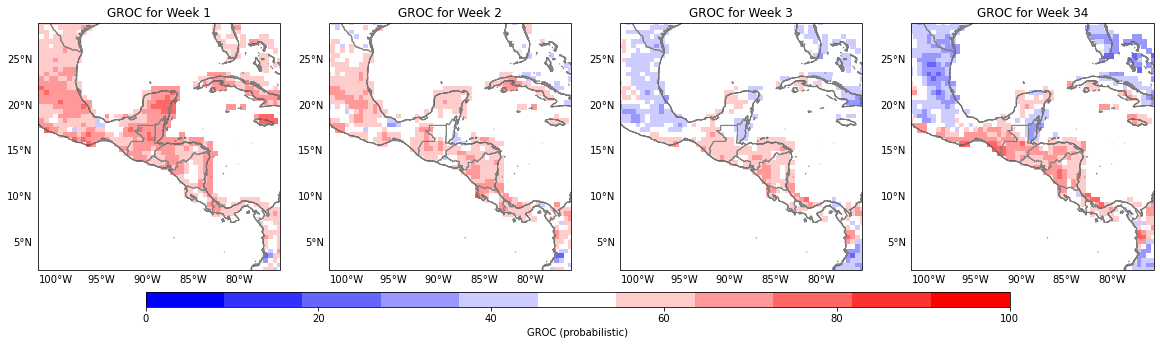

----------------------------------------------




PROCESS COMPLETED 


In [13]:
print("New folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
#for ime in ('Pearson','Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC'):
for ime in ('Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC'):
    pltmap(ime,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk, wk) 
    plt.savefig(('figures/Skill-'+model+'-'+obs+'-'+MOS+'-' + ime + '.pdf'), dpi=300)
    plt.show()
    print('----------------------------------------------')
    print('')
    
print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

### Regional summary (table)

In [14]:
print("Folder:")
%cd $workdir/output

#Desired scores: 
#score=('Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC')
score=('Spearman','2AFC','RocAbove','RocBelow')
#Coordinates of the box:
lon1=-82 #lon of upper left point of geographical sub-domain
lat1=20  #lat of upper left point of geographical sub-domain
lon2=-80 #lon of lower right point of geographical sub-domain
lat2=13  #lat of lower right point of geographical sub-domain
# Skill scores loop
df=skilltab(score,wknam,lon1,lat1,lat2,lon2,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk,wk)
df

Folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/output


,Spearman,max(Spearman),min(Spearman),2AFC,max(2AFC),min(2AFC),RocAbove,max(RocAbove),min(RocAbove),RocBelow,max(RocBelow),min(RocBelow)
Week 1,0.57,0.60,0.55,70.209999,71.230003,69.190002,0.79,0.80,0.79,0.74,0.74,0.73
Week 2,0.40,0.41,0.39,63.540001,63.919998,63.169998,0.78,0.79,0.77,0.68,0.69,0.67
Week 3,0.23,0.24,0.23,57.549999,57.759998,57.340000,0.69,0.72,0.67,0.56,0.58,0.54
Week 3-4,0.49,0.49,0.49,66.430000,66.470001,66.400002,0.75,0.76,0.75,0.71,0.71,0.71


## EOF Analysis (only available if MOS=PCR or CCA)

Present folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/output


Mode 1


<Figure size 1440x360 with 0 Axes>

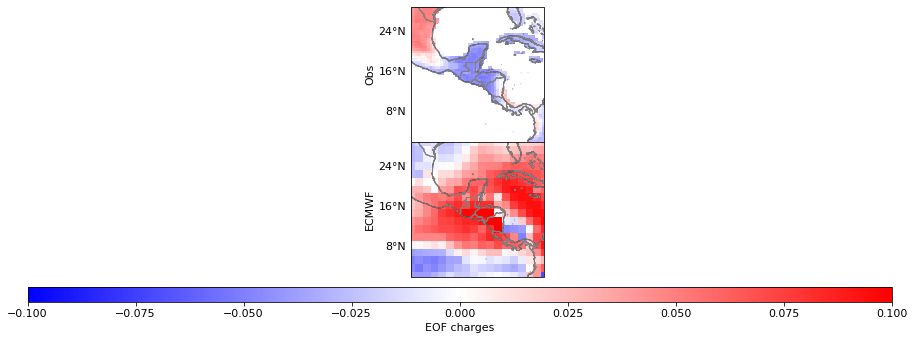

Mode 1


<Figure size 1440x360 with 0 Axes>

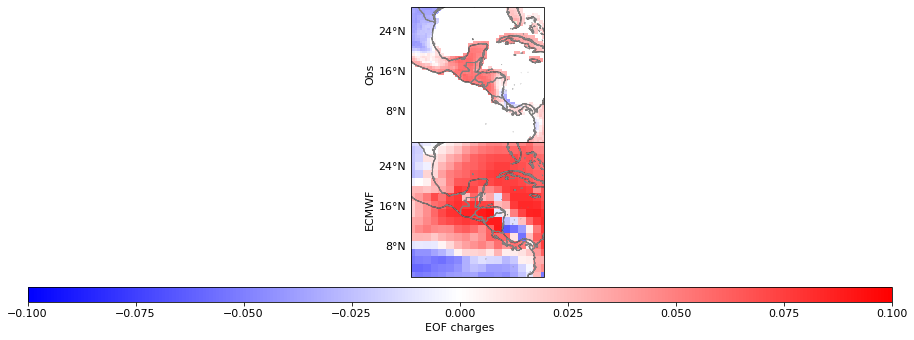

Mode 1


<Figure size 1440x360 with 0 Axes>

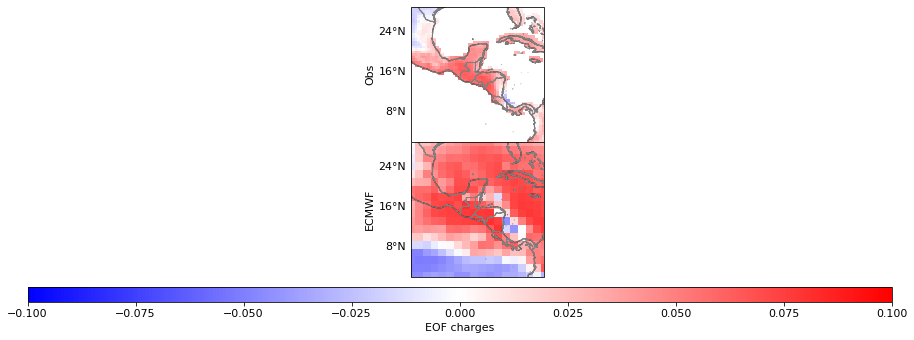

Mode 1


<Figure size 1440x360 with 0 Axes>

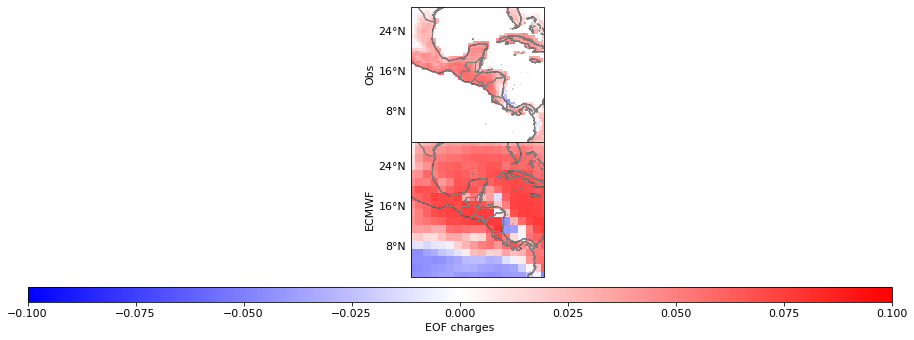

Mode 2


<Figure size 1440x360 with 0 Axes>

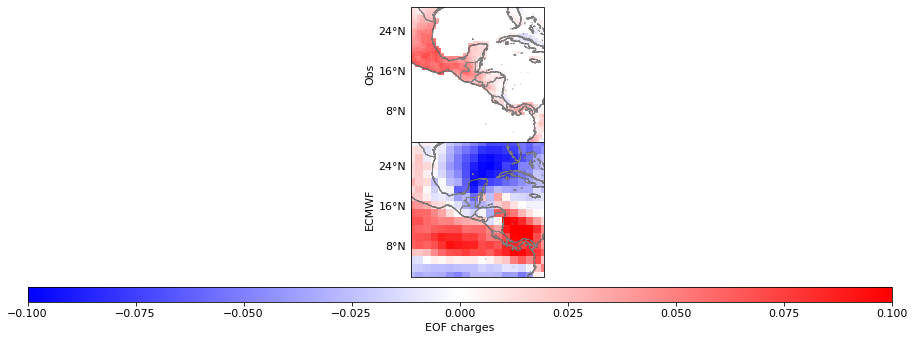

Mode 2


<Figure size 1440x360 with 0 Axes>

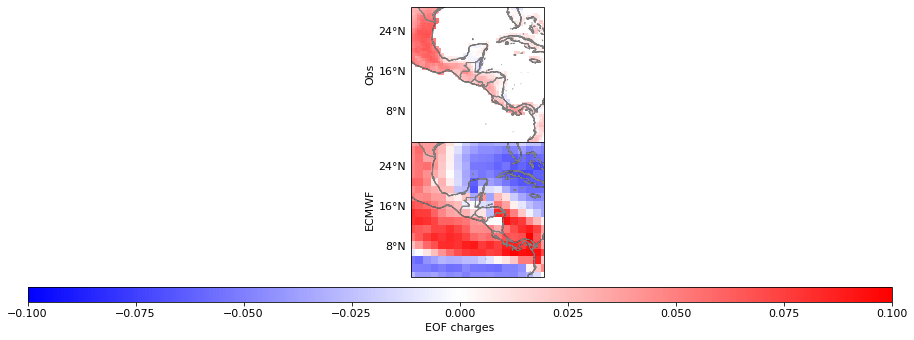

Mode 2


<Figure size 1440x360 with 0 Axes>

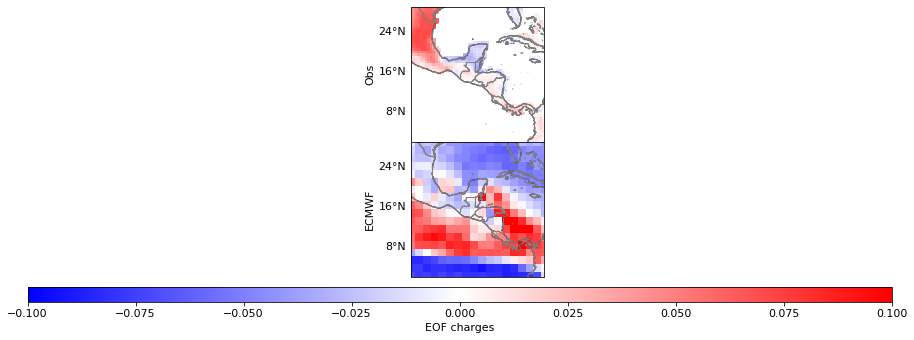

Mode 2


<Figure size 1440x360 with 0 Axes>

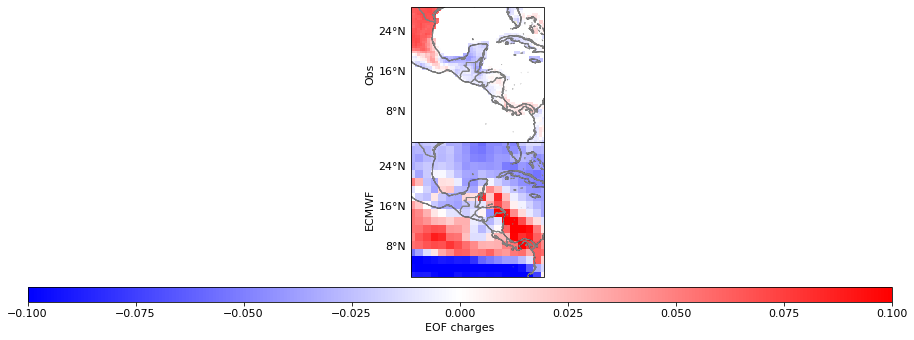

Mode 3


<Figure size 1440x360 with 0 Axes>

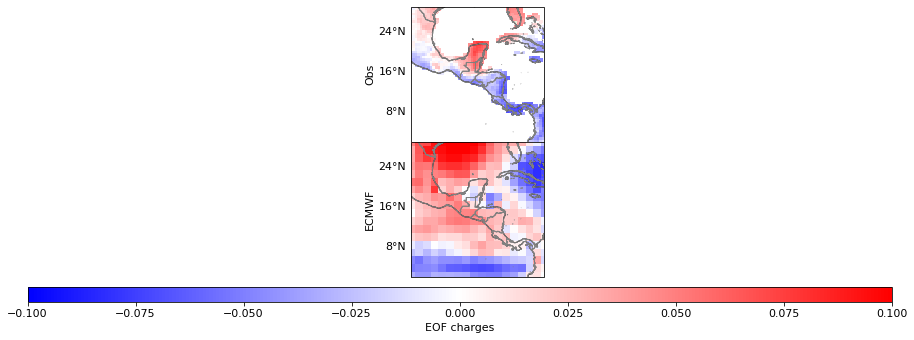

Mode 3


<Figure size 1440x360 with 0 Axes>

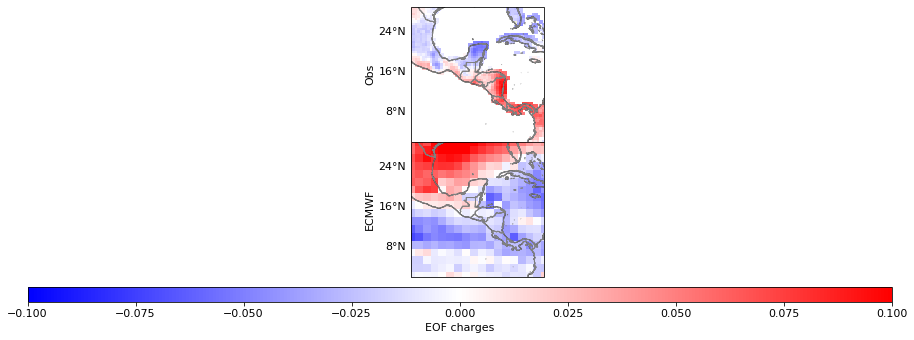

Mode 3


<Figure size 1440x360 with 0 Axes>

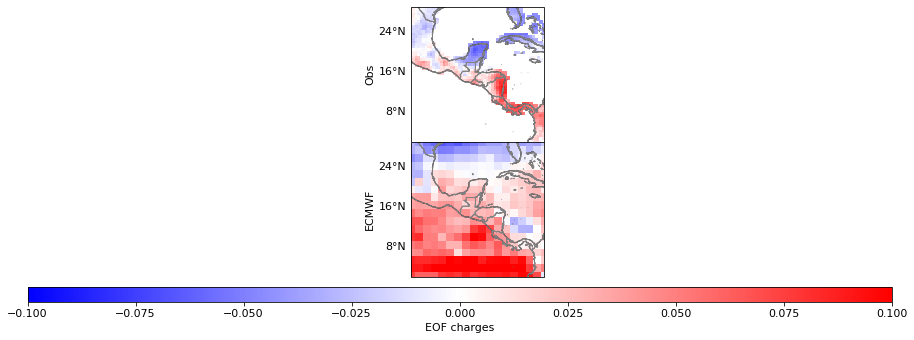

Mode 3


<Figure size 1440x360 with 0 Axes>

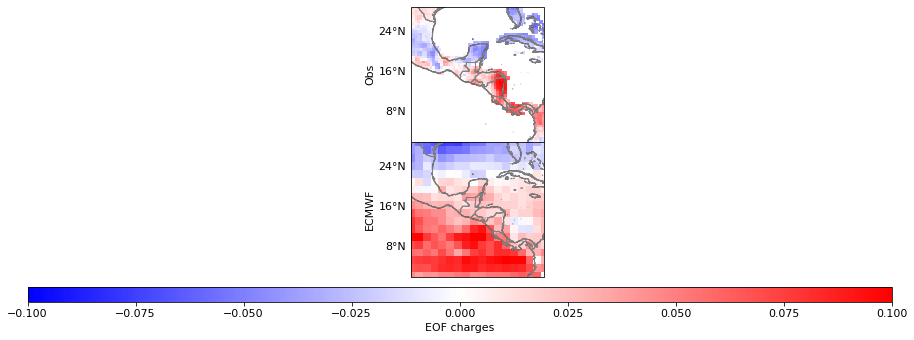

In [15]:
nmodes=3

print("Present folder:")
%cd $workdir/output
print('')
print('')

if MOS=='None':
    print("To compute EOFs you need to choose MOS=PCR or MOS=CCA")
else:
    # EOF loop
    plt.rcParams.update({'font.size': 11})
    for imod in range(nmodes):
        for L in range(nwk):
            plteofs(model,imod,nmodes,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,nwk, wk[L])
            print("\033[1mMode "+str(imod+1))
            plt.show()

## Forecast maps
Finally, this section deals with plotting deterministic and probabilistic forecasts.

Folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/output
----------------------------------------------



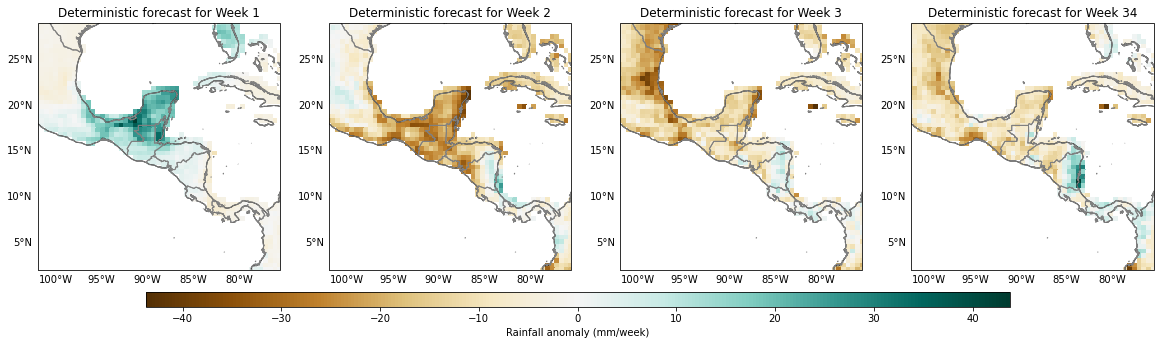

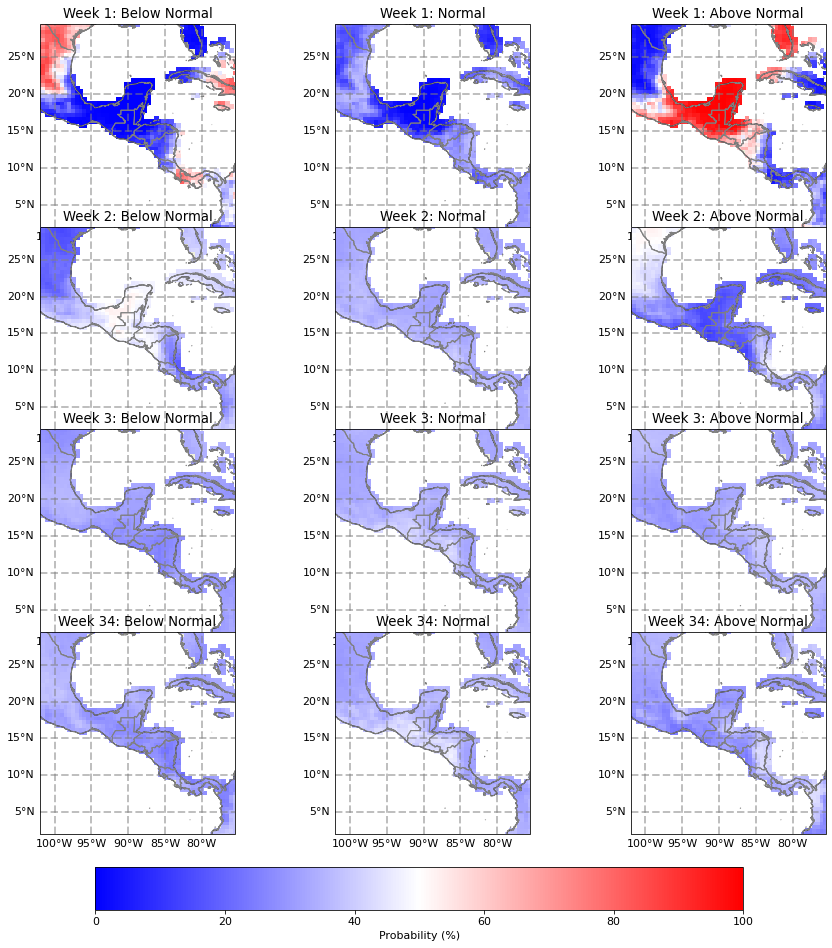

In [16]:
print("Folder:")
%cd $workdir/output

plt.rcParams.update({'font.size': 10})
pltmap(mpref+'FCST_V',wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk, wk)
plt.savefig('figures/Deterministic-'+model+'-'+obs+'-'+MOS+'.pdf', dpi=300)
print('----------------------------------------------')
print('')
plt.rcParams.update({'font.size': 11})
pltmapProb(wlo2,elo2,sla2,nla2,fprefix,mpref,training_season, mon, fday, nwk, wk)
plt.savefig('figures/ProbFcst'+model+'-'+obs+'-'+MOS+'.pdf', dpi=300)

### Flexible Forecasts
The user can choose between acual physical thresholds or percentiles, and those can be the same or different for different target weeks.

Folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/output


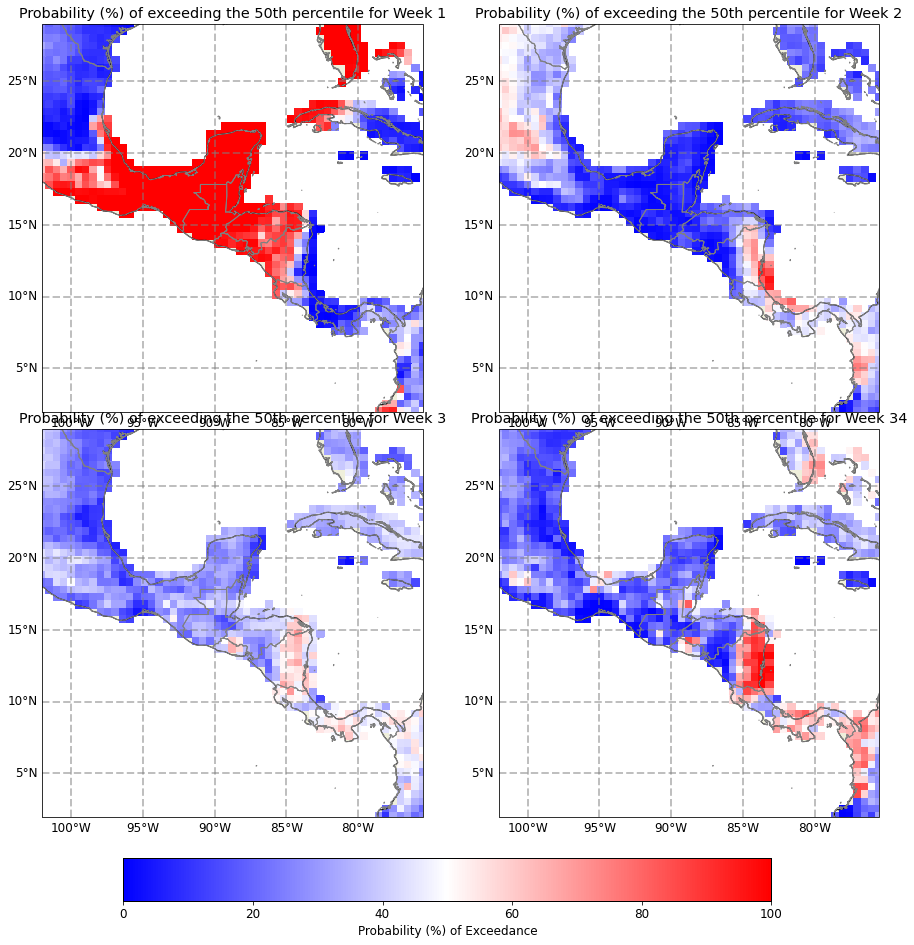

In [17]:
#threshold for the flexible format map (in mm/week -- remember: fcsts are in ANOMALIES!):
flexformat_threshold = [0.5,0.5,0.5,0.5] #array (we need one threshold per forecast week)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
if mpref=='noMOS' and fprefix=='PRCP':
    pltmapff(flexformat_threshold,ffthres_ispctl,ntrain,wlo1,elo1,sla1,nla1,fprefix,mpref,training_season,mon,fday,nwk,wk)
else:
    pltmapff(flexformat_threshold,ffthres_ispctl,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk,wk)
plt.savefig('figures/ProbFcst-Flexplt'+model+'-'+obs+'-'+MOS+'.pdf', dpi=300)

#### Flexible forecasts for a particular location
Select a location in the map and write down the coordinates in this section to visualize the probability density functions, probabilities of exceedances (and flexible verification --coming soon).

Folder:
/Users/kjhall/Desktop/iri-pycpt/IAS_s2s/IAS_s2s/output


<Figure size 1080x1080 with 0 Axes>

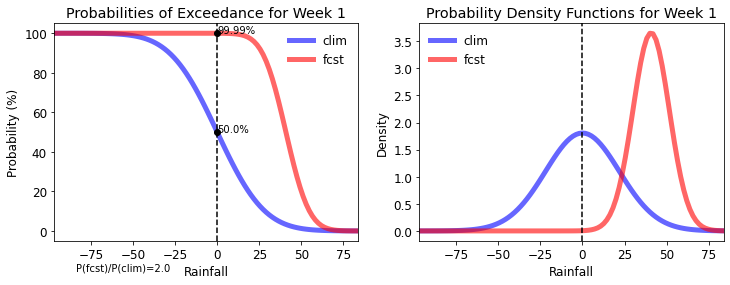

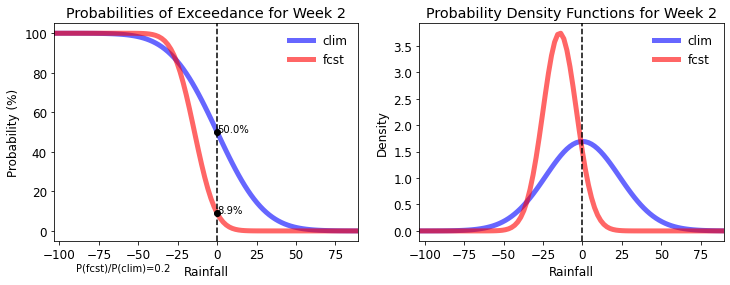

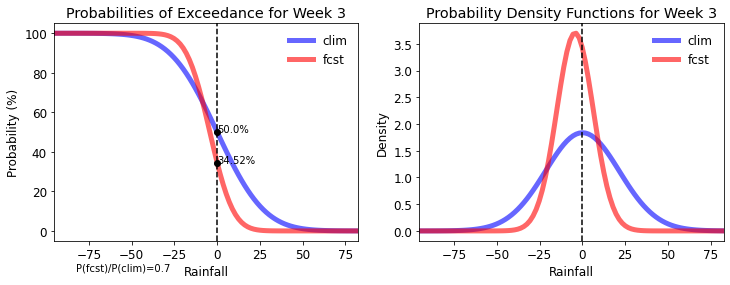

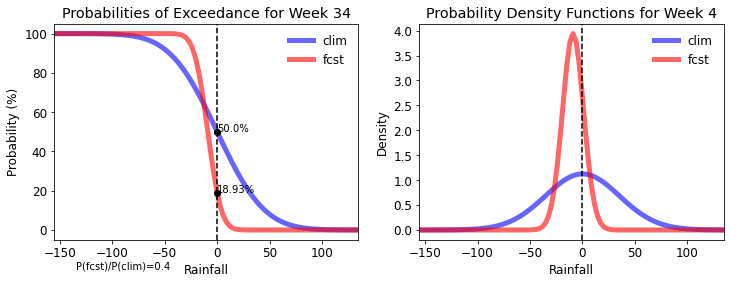

In [18]:
#threshold for the flexible format map (in mm/week -- remember: fcsts are in ANOMALIES!):
flexformat_threshold = [0.5,0.5,0.5,0.5] #array (we need one threshold per week to forecast)
ffthres_ispctl=True  #If True, flex format threshold is a percentile: 0.001 - 0.999
#Location coordinates:
lon=-90.2
lat=15.
 
print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(flexformat_threshold,ffthres_ispctl,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,training_season,mon,fday,nwk,wk)
plt.savefig('figures/ProbExceed-'+model+'-'+obs+'-'+MOS+'.pdf', dpi=300)